In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter

import matplotlib.pyplot as plt
import numpy as np
import itertools

import networkx as nx
import pandas as pd

from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn.inits import glorot, zeros

import os
import random
import time

In [ ]:
# 그래프 로드

def load_graph(filename):
    """karate.dat 파일을 로드하여 NetworkX 그래프로 변환"""
    G = nx.read_edgelist(filename, nodetype=int)

    # 셀프 루프 제거
    G.remove_edges_from(nx.selfloop_edges(G))

    # 노드 라벨 정리 (예: 0부터 시작하는 연속된 정수로 변경)
    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    return G

# 데이터 로드 및 전처리
test_graph = load_graph("/Dataset/football.dat")

In [ ]:
# 그래프 feature 추출
def get_node_features(G):
    """노드 특징 생성: Degree, PageRank, Clustering Coefficient, Coreness"""
    features = {}
    pagerank = nx.pagerank(G)
    clustering = nx.clustering(G)
    coreness = nx.core_number(G)

    for node in G.nodes():
        features[node] = [
            G.degree(node),           # Degree
            pagerank[node],           # PageRank
            clustering[node],         # Clustering Coefficient
            coreness[node]            # Coreness
        ]

    return features

# 그래프에 input, target 설정
def prepare_graph_data(graph, follower_counts):
    """NetworkX 그래프를 PyTorch Geometric 형식으로 변환, Target: Follower Count"""
    node_features = get_node_features(graph)
    data = from_networkx(graph)

    # 노드 특징을 PyTorch Tensor로 변환
    data.x = torch.tensor([node_features[n] for n in graph.nodes()], dtype=torch.float)

    # Follower 수를 Target 값으로 사용
    data.y = torch.tensor([follower_counts.get(n, 0) for n in graph.nodes()], dtype=torch.float).view(-1, 1)

    data.x = (data.x - torch.mean(data.x, dim=0)) / torch.std(data.x, dim=0)

    return data

# Follower 수 계산
def get_follower_counts(G):
    """각 노드가 제거될 때 영향을 받는 follower 수 계산

        returns : dict(node: follower count), dict(node: list of followers of node)

    """
    coreness = nx.core_number(G)
    follower_counts = {}
    follower_list = {}

    for node in G.nodes():
        node_follower = []
        G_copy = G.copy()
        G_copy.remove_node(node)
        new_coreness = nx.core_number(G_copy)

        # Follower 수는 Coreness 값이 변한 노드들의 개수
        followers = sum(1 for n in G.nodes() if coreness[n] != new_coreness.get(n, coreness[n]))
        node_follower.extend(n for n in G.nodes() if coreness[n] != new_coreness.get(n, coreness[n]))
        follower_list[node] = node_follower
        follower_counts[node] = followers

    return follower_counts, follower_list

# 팔로워 및 k-hop 이웃 subgraph
def create_follower_subgraph(G, follower_nodes, deleted_node, original_node_count, include_neighbors=0):
    """
    Follower 노드 및 삭제된 노드의 이웃 노드로 구성된 서브그래프 생성 함수

    Args:
        G (nx.Graph): 원본 그래프
        follower_nodes (list): Follower 노드 리스트
        deleted_node (int): 삭제된 노드
        original_node_count (int): 원본 그래프의 노드 수
        include_neighbors (int): 포함할 이웃 노드의 홉 수 (0=이웃 미포함, 1=1홉 이웃, 2=2홉 이웃)

    Returns:
        nx.Graph: 서브그래프
    """
    # 샘플링할 노드 집합 초기화 (follower 노드로 시작)
    sampled_nodes = set(follower_nodes)

    # 삭제된 노드의 이웃 추가 (홉 수에 따라)
    if include_neighbors > 0 and deleted_node in G.nodes():
        neighbors = set(G.neighbors(deleted_node))
        sampled_nodes.update(neighbors)  # 1홉 이웃 추가

        # 2홉 이상의 이웃 추가
        for _ in range(1, include_neighbors):
            next_neighbors = set()
            for node in neighbors:
                if node in G.nodes():
                    next_neighbors.update(G.neighbors(node))
            neighbors = next_neighbors - sampled_nodes
            sampled_nodes.update(neighbors)

    # 서브그래프 생성
    follower_subgraph = G.subgraph(sampled_nodes).copy()

    # 새로운 그래프 생성 (전체 노드 인덱스 유지)
    new_graph = nx.Graph()

    # 모든 원본 노드 인덱스 추가
    for i in range(original_node_count):
        new_graph.add_node(i)

    # 서브그래프의 엣지 추가
    for u, v in follower_subgraph.edges():
        new_graph.add_edge(u, v)

    return sampled_nodes, new_graph

In [ ]:
class GConvLSTM(torch.nn.Module):
    r"""An implementation of the Chebyshev Graph Convolutional Long Short Term Memory
    Cell. For details see this paper: `"Structured Sequence Modeling with Graph
    Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(GConvLSTM, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()
        self._set_parameters()

    def _create_input_gate_parameters_and_layers(self):

        self.conv_x_i = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_i = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.w_c_i = Parameter(torch.Tensor(1, self.out_channels))
        self.b_i = Parameter(torch.Tensor(1, self.out_channels))

    def _create_forget_gate_parameters_and_layers(self):

        self.conv_x_f = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_f = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.w_c_f = Parameter(torch.Tensor(1, self.out_channels))
        self.b_f = Parameter(torch.Tensor(1, self.out_channels))

    def _create_cell_state_parameters_and_layers(self):

        self.conv_x_c = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_c = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.b_c = Parameter(torch.Tensor(1, self.out_channels))

    def _create_output_gate_parameters_and_layers(self):

        self.conv_x_o = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_o = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.w_c_o = Parameter(torch.Tensor(1, self.out_channels))
        self.b_o = Parameter(torch.Tensor(1, self.out_channels))

    def _create_parameters_and_layers(self):
        self._create_input_gate_parameters_and_layers()
        self._create_forget_gate_parameters_and_layers()
        self._create_cell_state_parameters_and_layers()
        self._create_output_gate_parameters_and_layers()

    def _set_parameters(self):
        glorot(self.w_c_i)
        glorot(self.w_c_f)
        glorot(self.w_c_o)
        zeros(self.b_i)
        zeros(self.b_f)
        zeros(self.b_c)
        zeros(self.b_o)

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _set_cell_state(self, X, C):
        if C is None:
            C = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return C

    def _calculate_input_gate(self, X, edge_index, edge_weight, H, C, lambda_max):
        I = self.conv_x_i(X, edge_index, edge_weight, lambda_max=lambda_max)
        I = I + self.conv_h_i(H, edge_index, edge_weight, lambda_max=lambda_max)
        I = I + (self.w_c_i * C)
        I = I + self.b_i
        I = torch.sigmoid(I)
        return I

    def _calculate_forget_gate(self, X, edge_index, edge_weight, H, C, lambda_max):
        F = self.conv_x_f(X, edge_index, edge_weight, lambda_max=lambda_max)
        F = F + self.conv_h_f(H, edge_index, edge_weight, lambda_max=lambda_max)
        F = F + (self.w_c_f * C)
        F = F + self.b_f
        F = torch.sigmoid(F)
        return F

    def _calculate_cell_state(self, X, edge_index, edge_weight, H, C, I, F, lambda_max):
        T = self.conv_x_c(X, edge_index, edge_weight, lambda_max=lambda_max)
        T = T + self.conv_h_c(H, edge_index, edge_weight, lambda_max=lambda_max)
        T = T + self.b_c
        T = torch.tanh(T)
        C = F * C + I * T
        return C

    def _calculate_output_gate(self, X, edge_index, edge_weight, H, C, lambda_max):
        O = self.conv_x_o(X, edge_index, edge_weight, lambda_max=lambda_max)
        O = O + self.conv_h_o(H, edge_index, edge_weight, lambda_max=lambda_max)
        O = O + (self.w_c_o * C)
        O = O + self.b_o
        O = torch.sigmoid(O)
        return O

    def _calculate_hidden_state(self, O, C):
        H = O * torch.tanh(C)
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
        C: torch.FloatTensor = None,
        lambda_max: torch.Tensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state and cell state
        matrices are not present when the forward pass is called these are
        initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.
            * **C** *(PyTorch Float Tensor, optional)* - Cell state matrix for all nodes.
            * **lambda_max** *(PyTorch Tensor, optional but mandatory if normalization is not sym)* - Largest eigenvalue of Laplacian.

        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
            * **C** *(PyTorch Float Tensor)* - Cell state matrix for all nodes.
        """
        H = self._set_hidden_state(X, H)
        C = self._set_cell_state(X, C)
        I = self._calculate_input_gate(X, edge_index, edge_weight, H, C, lambda_max)
        F = self._calculate_forget_gate(X, edge_index, edge_weight, H, C, lambda_max)
        C = self._calculate_cell_state(X, edge_index, edge_weight, H, C, I, F, lambda_max)
        O = self._calculate_output_gate(X, edge_index, edge_weight, H, C, lambda_max)
        H = self._calculate_hidden_state(O, C)
        return H, C

In [ ]:
# GConvLSTM 모델
class GLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, k, fc_hidden_dim, output_dim):
        super(GLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.fc_hidden_dim = fc_hidden_dim
        self.output_dim = output_dim

        self.lstm = GConvLSTM(self.input_dim, self.hidden_dim, self.k)
        self.fc1 = nn.Linear(self.hidden_dim, self.fc_hidden_dim)
        self.fc2 = nn.Linear(self.fc_hidden_dim, self.output_dim)

    def forward(self, data):
        x, edge_index = data[0].x, data[0].edge_index
        h, c = self.lstm(X=x, edge_index=edge_index)
        if len(data) > 1:
            for i in range(1, len(data)):
                x, edge_index = data[i].x, data[i].edge_index
                h, c = self.lstm(X=x, edge_index=edge_index, H=h, C=c)

        x = self.fc1(h)
        x = F.relu(x)
        x = self.fc2(x)

        y = data[-1].y

        return x, y

# GCN 모델
class GCNModel(nn.Module):
    """Follower 예측을 위한 GCN 모델"""
    def __init__(self, input_dim, hidden_dim, fc_input_dim, fc_hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, fc_input_dim)
        self.fc1 = nn.Linear(fc_input_dim, fc_hidden_dim)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
# EWC

class EWC:
    """Elastic Weight Consolidation (EWC)"""
    def __init__(self, device, model_type, model, data, lambda_ewc, criterion):
        self.model_type = model_type
        self.model = model.to(device)
        self.data = data
        self.lambda_ewc = lambda_ewc
        self.criterion = criterion
        self.fisher_information = self.calculate_fisher_information()

    def calculate_fisher_information(self):
        """피셔 정보 행렬 계산"""
        fisher_information = {}
        for name, param in self.model.named_parameters():
            fisher_information[name] = torch.zeros_like(param)

        self.model.eval()
        self.model.zero_grad()

        if self.model_type == "GConvLSTM":
            output, y = self.model(self.data)
            loss = self.criterion(output, y)
        elif self.model_type == "GCN":
            output = self.model(self.data)
            loss = self.criterion(output, self.data.y)
        else:
            raise NameError("model type must be GConvLSTM or GCN")
        loss.backward()

        for name, param in self.model.named_parameters():
            fisher_information[name] += param.grad.data ** 2

        return fisher_information

    def penalty(self, model):
        """EWC 손실 항 계산"""
        loss = 0
        for name, param in model.named_parameters():
            fisher_term = self.fisher_information[name]
            loss += (fisher_term * (param - param.data) ** 2).sum()
        return self.lambda_ewc * loss

    def update_fisher_information(self, new_fisher_information):
        """피셔 정보 업데이트"""
        for name, fisher_old in self.fisher_information.items():
            fisher_new = new_fisher_information[name]
            self.fisher_information[name] = torch.sqrt(fisher_old * fisher_new)


In [ ]:
# EWC 적용 훈련 함수
def train_model(model_type, model, optimizer, data, ewc, lambda_ewc, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        if model_type == "GConvLSTM":
            output, y = model(data)
            loss = criterion(output, y)
        elif model_type == "GCN":
            output = model(data)
            loss = criterion(output, data.y)
        else:
            raise NameError("model_type must be GConvLSTM or GCN")

        # EWC 손실 항 추가
        if ewc is not None:
            ewc_loss = ewc.penalty(model)
            loss += lambda_ewc * ewc_loss

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

In [ ]:
# GConvLSTM + Test-train

def GConvLSTM_test_train(device, graph, budget, model_type, model, criterion, lambda_ewc=400,
                         initial_epochs=200, continual_epochs=100, learning_rate=0.01, use_ewc=True):
    G = graph.copy()
    original_coreness = nx.core_number(graph)
    original_sum = sum(original_coreness.values())
    start_time = time.time()
    total_removed = [0]
    removed_nodes = []
    input_data = []

    # 모델 설정
    if model is None:
      input_dim = 4
      hidden_dim = 64
      k = 3
      fc_hidden_dim = 128
      output_dim = 1

      model = GLSTM(
          input_dim=input_dim,
          hidden_dim=hidden_dim,
          k=k,
          fc_hidden_dim=fc_hidden_dim,
          output_dim=output_dim
      ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 초기 follower 계산
    follower_counts, follower_lists = get_follower_counts(G)

    # 초기 데이터 준비
    test_data = prepare_graph_data(G, follower_counts)
    test_data = test_data.to(device)
    input_data.append(test_data)

    # 전체 그래프에 대한 초기 학습
    train_model(model_type, model, optimizer, input_data, None, lambda_ewc, criterion, epochs=initial_epochs)

    # EWC 초기화
    if use_ewc:
      ewc = EWC(device, model_type, model, input_data, lambda_ewc, criterion)
    else:
      ewc = None

    for iteration in range(budget):
      if not G.nodes:
        break

      original_graph = graph.copy()

      if iteration <= 1:
        model.eval()
        with torch.no_grad():
          predicted_followers, _ = model(input_data)
          predicted_followers = predicted_followers.cpu().numpy().flatten()

        # 노드별 예측 follower 매핑
        node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

        # 예측 follower가 가장 많은 노드
        target_node = max(node_follower_map, key=node_follower_map.get)
        removed_nodes.append(target_node)

        # 노드 제거
        G.remove_edges_from(list(G.edges(target_node)))

        # 원래 그래프에서 제거된 노드를 한 번에 제거
        original_graph.remove_nodes_from(removed_nodes)

        # 제거 후 coreness sum
        after_coreness = nx.core_number(original_graph)
        after_sum = sum(after_coreness.values())

        # Coreness loss 측정
        coreness_loss = original_sum - after_sum
        for n in removed_nodes:
          coreness_loss -= original_coreness[n]

        # coreness loss 누적
        total_removed.append(coreness_loss)

        # 팔로워 새롭게 구하기
        follower_counts, _ = get_follower_counts(G)

        # input graph 추가
        test_data = prepare_graph_data(G, follower_counts).to(device)
        input_data.append(test_data)
        continue

      # 그래프 학습
      train_model(model_type, model, optimizer, input_data[:-1], ewc, lambda_ewc, criterion, epochs=continual_epochs)
      ewc.update_fisher_information(ewc.calculate_fisher_information())

      # 현재 follower 예측
      model.eval()
      with torch.no_grad():
        predicted_followers, _ = model(input_data)
        predicted_followers = predicted_followers.cpu().numpy().flatten()

      # 노드별 예측 follower 매핑
      node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

      # 예측 follower가 가장 많은 노드
      target_node = max(node_follower_map, key=node_follower_map.get)
      removed_nodes.append(target_node)

      # 노드 제거
      G.remove_edges_from(list(G.edges(target_node)))

      # 원래 그래프에서 제거된 노드를 한 번에 제거
      original_graph.remove_nodes_from(removed_nodes)

      # 제거 후 coreness sum
      after_coreness = nx.core_number(original_graph)
      after_sum = sum(after_coreness.values())

      # Coreness loss 측정
      coreness_loss = original_sum - after_sum
      for n in removed_nodes:
        coreness_loss -= original_coreness[n]

      # coreness loss 누적
      total_removed.append(coreness_loss)

      # 팔로워 새롭게 구하기
      follower_counts, _ = get_follower_counts(G)

      # input graph 추가
      test_data = prepare_graph_data(G, follower_counts).to(device)
      input_data.append(test_data)

    end_time = time.time()
    return total_removed, removed_nodes, end_time - start_time

In [ ]:
# GConvLSTM + Partial

def GConvLSTM_sample(device, graph, budget, model_type, model, criterion, hop=2, lambda_ewc=400,
                     initial_epochs=200, continual_epochs=100, learning_rate=0.01, use_ewc=True):
    """
    노드 샘플링을 이용한 연속 학습 함수

    Args:
        graph (nx.Graph): 학습에 사용할 그래프
        budget (int): 제거할 노드 수
        model (GLSTM, optional): 사전 학습된 모델 (없으면 새로 생성)
        lambda_ewc (float): EWC 가중치
        use_ewc (bool): EWC 사용 여부
        initial_epochs (int): 초기 학습 epoch 수
        continual_epochs (int): 연속 학습 epoch 수
        learning_rate (float): 학습률
        verbose (bool): 상세 출력 여부

    Returns:
        tuple: (total_removed, model, execution_time)
        - total removed (list): 누적 제거된 follower count
        - model (GLSTM): 학습된 모델
        - execution_time (float): 실행 시간
    """
    start_time = time.time()
    G = graph.copy()
    original_node_count = G.number_of_nodes()
    original_coreness = nx.core_number(graph)
    original_sum = sum(original_coreness.values())

    # 모델 설정
    if model is None:
        # 모델 파라미터 설정
        input_dim = 4 # Degree, PageRank, Clustering Coefficient, Coreness
        hidden_dim = 64
        k = 3 # Chebyshev convolution
        fc_hidden_dim = 128
        output_dim = 1

        model = GLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            k=k,
            fc_hidden_dim=fc_hidden_dim,
            output_dim=output_dim
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 결과 저장 변수
    total_removed = [0] # 누적 제거된 follower count
    train_sequence = []  # 학습에 사용할 data sequence
    test_sequence = []  # 테스트에 사용할 data sequence
    removed_nodes = []

    # 원본 그래프의 follower count 계산
    follower_counts, follower_lists = get_follower_counts(G)

    # 초기 데이터 준비
    test_data = prepare_graph_data(G, follower_counts)
    test_data = test_data.to(device)
    train_sequence.append(test_data)
    test_sequence.append(test_data)

    # 반복적으로 노드 제거 및 재학습
    for iteration in range(budget):
        original_graph = graph.copy()

        if not G.nodes:
            break

        if iteration == 0:
          # 전체 그래프에 대한 초기 학습
          train_model(model_type, model, optimizer, train_sequence, None, lambda_ewc, criterion, epochs=initial_epochs)
          if use_ewc:
            ewc = EWC(device, model_type, model, train_sequence, lambda_ewc, criterion)
          else:
              ewc = None
        else:
          # 이후 학습
          train_model(model_type, model, optimizer, train_sequence, ewc, lambda_ewc, criterion, epochs=continual_epochs)
          if use_ewc:
            ewc.update_fisher_information(ewc.calculate_fisher_information())
          else:
              pass

        # Follower 예측
        with torch.no_grad():
          predicted_followers, _ = model(test_sequence)
          predicted_followers = predicted_followers.cpu().numpy().flatten()

        # 노드별 에측 follower 매핑
        node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

        # 예측 follower가 가장 많은 노드
        target_node = max(node_follower_map, key=node_follower_map.get)
        removed_nodes.append(target_node)

        # 선택된 노드의 followers
        actual_followers = follower_lists[target_node]

        # follower + neighbor의 subgraph
        sampled_nodes, train_graph = create_follower_subgraph(
            G, actual_followers, target_node, original_node_count, hop
        )

        # 선택된 노드 제거
        G.remove_edges_from(list(G.edges(target_node)))

        # 원래 그래프에서 제거된 노드들 한 번에 제거
        original_graph.remove_nodes_from(removed_nodes)

        # 제거 후 coreness sum
        after_coreness = nx.core_number(original_graph)
        after_sum = sum(after_coreness.values())

        # Coreness loss 측정
        coreness_loss = original_sum - after_sum
        for n in removed_nodes:
            coreness_loss -= original_coreness[n]

        # coreness loss 누적
        total_removed.append(coreness_loss)

        # 노드 제거한 후 각 노드의 follower 정보
        follower_counts, follower_lists = get_follower_counts(G)

        # train data 생성
        train_data = prepare_graph_data(train_graph, follower_counts)
        train_data = train_data.to(device)

        # 이전 그래프 정보 가져오기
        for n in sampled_nodes:
            test_data.x[n] = train_data.x[n]
            test_data.y[n] = train_data.y[n]
        train_data.x = test_data.x
        train_data.y = test_data.y

        # train sequence 추가
        train_sequence.append(train_data)

        # test sequence 추가
        test_data = prepare_graph_data(G, follower_counts)
        test_data = test_data.to(device)
        test_sequence.append(test_data)

        # 엣지 정보 복사
        train_sequence[-1].edge_index = test_data.edge_index

        # 이전 그래프의 그래프 업데이트
        if iteration >= 1:
          train_sequence[iteration] = test_sequence[iteration]

    execution_time = time.time() - start_time

    return total_removed, removed_nodes, execution_time

In [ ]:
# GConvLSTM combined

def GConvLSTM_combine(device, graph, budget, model_type, model, criterion, hop=2, lambda_ewc=400,
                      inital_epochs=200, continual_epochs=100, learning_rate=0.01, use_ewc=True):
    """
    GLSTM으로 노드 샘플링 연속 학습 수행 (test-train 방법 적용)

    Args:
        graph (nx.Graph): 학습에 사용할 그래프
        budget (int): 제거할 노드 수
        model (GLSTM, optional): 사전 학습된 모델 (없으면 새로 생성)
        lambda_ewc (float): EWC 가중치
        use_ewc (bool): EWC 사용 여부
        initial_epochs (int): 초기 학습 에폭 수
        continual_epochs (int): 연속 학습 에폭 수
        learning_rate (float): 학습률
        include_neighbors (int): 삭제된 노드의 이웃을 몇 홉까지 포함할지 결정

    Returns:
        tuple: (total_removed, removed_nodes, execution_time)
        - total_removed (list): 누적 coreness loss
        - removed_nodes (list): 제거된 노드 목록
        - execution_time (float): 실행 시간
    """
    start_time = time.time()

    # 학습용 그래프
    G = graph.copy()
    original_node_count = G.number_of_nodes()
    original_coreness = nx.core_number(graph)
    original_sum = sum(original_coreness.values())

    # 결과 저장 변수
    total_removed = [0]
    removed_nodes = []
    train_sequence = []
    test_sequence = []

    # 모델 설정
    if model is None:
        input_dim = 4
        hidden_dim = 64
        k = 3
        fc_hidden_dim = 128
        output_dim = 1

        model = GLSTM(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            k=k,
            fc_hidden_dim=fc_hidden_dim,
            output_dim=output_dim
        ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 초기 follower 계산
    follower_counts, follower_lists = get_follower_counts(G)

    # 초기 데이터 준비
    initial_data = prepare_graph_data(G, follower_counts)
    test_data = initial_data.to(device)
    train_sequence.append(test_data)
    test_sequence.append(test_data)

    # 전체 그래프에 대한 초기 학습
    train_model(model_type, model, optimizer, train_sequence, None, lambda_ewc, criterion, epochs=inital_epochs)

    # EWC 초기화
    if use_ewc:
        ewc_lstm = EWC(device, model_type, model, train_sequence, lambda_ewc, criterion)
    else:
        ewc_lstm = None

    for iteration in range(budget):
        if not G.nodes:
            break

        original_graph = graph.copy()

        if iteration <= 1:
            # Follower 예측
            model.eval()
            with torch.no_grad():
                predicted_followers, _ = model(test_sequence)
                predicted_followers = predicted_followers.cpu().numpy().flatten()

            # 노드별 예측 follower 매핑
            node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

            # 예측 follower가 가장 많은 노드
            target_node = max(node_follower_map, key=node_follower_map.get)
            removed_nodes.append(target_node)

            # 선택된 노드의 followers
            actual_followers = follower_lists[target_node]

            # follower + neighbor의 subgraph
            sampled_nodes, train_graph = create_follower_subgraph(
                G, actual_followers, target_node, original_node_count, hop
                )

            # 선택된 노드 제거
            G.remove_edges_from(list(G.edges(target_node)))

            # 원래 그래프에서 제거된 노드들 한 번에 제거
            original_graph.remove_nodes_from(removed_nodes)

            # 제거 후 coreness sum
            after_coreness = nx.core_number(original_graph)
            after_sum = sum(after_coreness.values())

            # Coreness loss 측정
            coreness_loss = original_sum - after_sum
            for n in removed_nodes:
                coreness_loss -= original_coreness[n]

            # coreness loss 누적
            total_removed.append(coreness_loss)

            # 노드 제거한 후 각 노드의 follower 정보
            follower_counts, follower_lists = get_follower_counts(G)

            # train data 생성
            train_data = prepare_graph_data(train_graph, follower_counts)
            train_data = train_data.to(device)

            # 이전 그래프 정보 가져오기
            for n in sampled_nodes:
                test_data.x[n] = train_data.x[n]
                test_data.y[n] = train_data.y[n]
            train_data.x = test_data.x
            train_data.y = test_data.y

            # train sequence 추가
            train_sequence.append(train_data)

            # test sequence 추가
            test_data = prepare_graph_data(G, follower_counts)
            test_data = test_data.to(device)
            test_sequence.append(test_data)

            # 엣지 정보 복사
            train_sequence[-1].edge_index = test_data.edge_index
            continue

        # 모델 훈련
        train_model(model_type, model, optimizer, train_sequence[:-1], ewc_lstm, lambda_ewc, criterion, epochs=continual_epochs)

        if use_ewc:
            ewc_lstm.update_fisher_information(ewc_lstm.calculate_fisher_information())

        # 예측측
        model.eval()
        with torch.no_grad():
            predicted_followers, _ = model(test_sequence)
            predicted_followers = predicted_followers.cpu().numpy().flatten()

        # 노드별 예측 follower 매핑
        node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

        # 예측 follower가 가장 많은 노드
        target_node = max(node_follower_map, key=node_follower_map.get)
        removed_nodes.append(target_node)

        # 선택된 노드의 followers
        actual_followers = follower_lists[target_node]

        # follower + neighbor의 subgraph
        sampled_nodes, train_graph = create_follower_subgraph(
            G, actual_followers, target_node, original_node_count, 2
        )

        # 선택된 노드 제거
        G.remove_edges_from(list(G.edges(target_node)))

        # 원래 그래프에서 제거된 노드를 한 번에 제거
        original_graph.remove_nodes_from(removed_nodes)

        # 제거 후 coreness sum
        after_coreness = nx.core_number(original_graph)
        after_sum = sum(after_coreness.values())

        # Coreness loss 측정
        coreness_loss = original_sum - after_sum
        for n in removed_nodes:
            coreness_loss -= original_coreness[n]

        # coreness loss 누적
        total_removed.append(coreness_loss)

        # 노드 제거한 후 각 노드의 follower 정보
        follower_counts, follower_lists = get_follower_counts(G)

        # train data 생성
        train_data = prepare_graph_data(train_graph, follower_counts)
        train_data = train_data.to(device)

        # 이전 그래프 정보 가져오기
        for n in sampled_nodes:
            test_data.x[n] = train_data.x[n]
            test_data.y[n] = train_data.y[n]
        train_data.x = test_data.x
        train_data.y = test_data.y

        # train_sequence 추가
        train_sequence.append(train_data)
        train_sequence[iteration-1] = test_sequence[iteration-1]

        # test sequence 추가
        test_data = prepare_graph_data(G, follower_counts)
        test_data = test_data.to(device)
        test_sequence.append(test_data)

        # 엣지 정보 복사
        train_sequence[-1].edge_index = test_data.edge_index

    execution_time = time.time() - start_time

    return total_removed, removed_nodes, execution_time

In [ ]:
# GCN + Partial

def GCN_sample(device, graph, budget, model_type, model, criterion, hop=2, lambda_ewc=400,
               initial_epochs=200, continual_epochs=100, learning_rate=0.01, use_ewc=True):
    start_time = time.time()
    G = graph.copy()
    original_node_count = G.number_of_nodes()
    original_coreness = nx.core_number(graph)
    original_sum = sum(original_coreness.values())

    # 모델 설정
    if model is None:
        input_dim = 4
        hidden_dim = 64
        fc_input_dim = 128
        fc_hidden_dim = 128
        output_dim = 1

        model = GCNModel(input_dim=input_dim,
                         hidden_dim=hidden_dim,
                         fc_input_dim=fc_input_dim,
                         fc_hidden_dim=fc_hidden_dim,
                         output_dim=output_dim).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_removed = [0]
    removed_nodes = []

    # 초기 follower 계산
    follower_counts, follower_lists = get_follower_counts(G)

    # 초기 데이터 준비
    test_data = prepare_graph_data(G, follower_counts)
    test_data = test_data.to(device)
    train_input = test_data
    test_input = test_data

    for iteration in range(budget):
        original_graph = graph.copy()

        if not G.nodes:
            break

        if iteration == 0:
            # 전체 그래프에 대한 초기 학습
            train_model(model_type, model, optimizer, train_input, None, lambda_ewc, criterion, epochs=initial_epochs)
            if use_ewc:
                ewc = EWC(device, model_type, model, train_input, lambda_ewc, criterion)
        else:
            # 이후 학습
            train_model(model_type, model, optimizer, train_input, ewc, lambda_ewc, criterion, epochs=continual_epochs)
            if use_ewc:
                ewc.update_fisher_information(ewc.calculate_fisher_information())

        # Follower 예측
        with torch.no_grad():
            predicted_followers = model(test_input)
            predicted_followers = predicted_followers.cpu().numpy().flatten()

        # 노드별 예측 follower 매핑
        node_follower_map = {node: predicted_followers[node] for node in G.nodes()}

        # 예측 follower가 가장 많은 노드
        target_node = max(node_follower_map, key=node_follower_map.get)
        removed_nodes.append(target_node)

        # 선택된 노드의 followers
        actual_followers = follower_lists[target_node]

        # Follower + neighbor의 subgraph
        sampled_nodes, train_graph = create_follower_subgraph(
            G, actual_followers, target_node, original_node_count, hop
        )

        # 선택된 노드 제거
        G.remove_edges_from(list(G.edges(target_node)))

        # 원래 그래프에서 제거된 노드들 한 번에 제거
        original_graph.remove_nodes_from(removed_nodes)

        # 제거 후 coreness sum
        after_coreness = nx.core_number(original_graph)
        after_sum = sum(after_coreness.values())

        # Coreness loss 측정
        coreness_loss = original_sum - after_sum
        for n in removed_nodes:
            coreness_loss -= original_coreness[n]

        # Coreness loss 누적
        total_removed.append(coreness_loss)

        # 노드 제거한 후 각 노드의 follower 정보
        follower_counts, follower_lists = get_follower_counts(G)

        # Train data 생성
        train_data = prepare_graph_data(train_graph, follower_counts)
        train_data = train_data.to(device)

        # 이전 그래프 정보 가져오기
        for n in sampled_nodes:
            test_data.x[n] = train_data.x[n]
            test_data.y[n] = train_data.y[n]
        train_data.x = test_data.x
        train_data.y = test_data.y

        # Train sequence 추가
        train_input = train_data

        # Test sequence 추가
        test_data = prepare_graph_data(G, follower_counts)
        test_data = test_data.to(device)
        test_input = test_data

        # 엣지 정보 복사
        train_input.edge_index = test_data.edge_index

    execution_time = time.time() - start_time

    return total_removed, removed_nodes, execution_time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
budget = 10
criterion = nn.MSELoss()
hop = 2
lambda_ewc = 400
initial_epochs = 200
continual_epochs = 100
learning_rate = 0.01
use_ewc = True

lstm_test_train = []
lstm_sample = []
lstm_combine = []
gcn = []

for iteration in range(20):
    print(iteration)

    print("GConvLSTM Test-train")
    lstm_test_train_loss, lstm_test_train_removed, _ = GConvLSTM_test_train(device, test_graph.copy(), budget, "GConvLSTM",
                                                                            None, criterion)
    lstm_test_train.append(lstm_test_train_loss)

    print("GConvLSTM Sample")
    lstm_sample_loss, lstm_sample_removed, _ = GConvLSTM_sample(device, test_graph.copy(), budget, "GConvLSTM",
                                                                None, criterion)
    lstm_sample.append(lstm_sample_loss)

    print("GConvLSTM Combined")
    lstm_combine_loss, lstm_combine_removed, _ = GConvLSTM_combine(device, test_graph.copy(), budget, "GConvLSTM",
                                                                   None, criterion)
    lstm_combine.append(lstm_combine_loss)

    print("GCN Sample")
    gcn_sample_loss, gcn_sample_removed, _ = GCN_sample(device, test_graph.copy(), budget, "GCN",
                                                        None, criterion)
    gcn.append(gcn_sample_loss)

lstm_test_train_mean = np.mean(lstm_test_train, axis=0)
lstm_sample_mean = np.mean(lstm_sample, axis=0)
lstm_combine_mean = np.mean(lstm_combine, axis=0)
gcn_sample_mean = np.mean(gcn, axis=0)

lstm_test_train_std = np.std(lstm_test_train, axis=0)
lstm_sample_std = np.std(lstm_sample, axis=0)
lstm_combine_std = np.std(lstm_combine, axis=0)
gcn_sample_std = np.std(gcn, axis=0)

In [ ]:
all_outputs = {
    "lstm_test_train": lstm_test_train,
    "lstm_sample": lstm_sample,
    "lstm_combine": lstm_combine,
    "gcn": gcn
}

colors = {
    "lstm_test_train": "red",
    "lstm_sample": "green",
    "lstm_combine": "orange",
    "gcn": "black"
}

marker = {
    "lstm_test_train": "-^",
    "lstm_sample": "-o",
    "lstm_combine": "-s",
    "gcn": "-*"
}

In [ ]:
football = [0, 6, 19, 29, 37, 56, 81, 95, 105, 115, 123]
karate = [0, 18, 27, 41, 47, 50]
mexican = [0, 28, 31, 39, 45, 54]
strike = [0, 4, 7, 10, 12, 16]

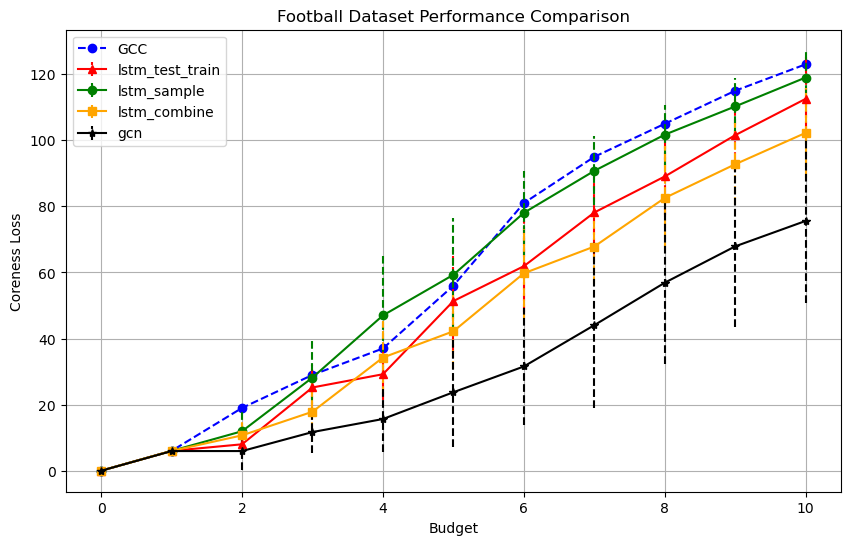

In [ ]:
def compare_performance(gcc, all_data):
    plt.figure(figsize=(10,6))

    plt.plot(range(len(gcc)), gcc, label="GCC", marker="o", linestyle="--", color="blue")

    for label, data in all_data.items():
        means = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        line, caplines, barlines = plt.errorbar(np.arange(len(gcc)), means, fmt=marker[label], yerr=std, label=label, color=colors[label])

        for bar in barlines:
            bar.set_linestyle("--")

    plt.xlabel("Budget")
    plt.ylabel("Coreness Loss")
    plt.title("Football Dataset Performance Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

compare_performance(football, all_outputs)

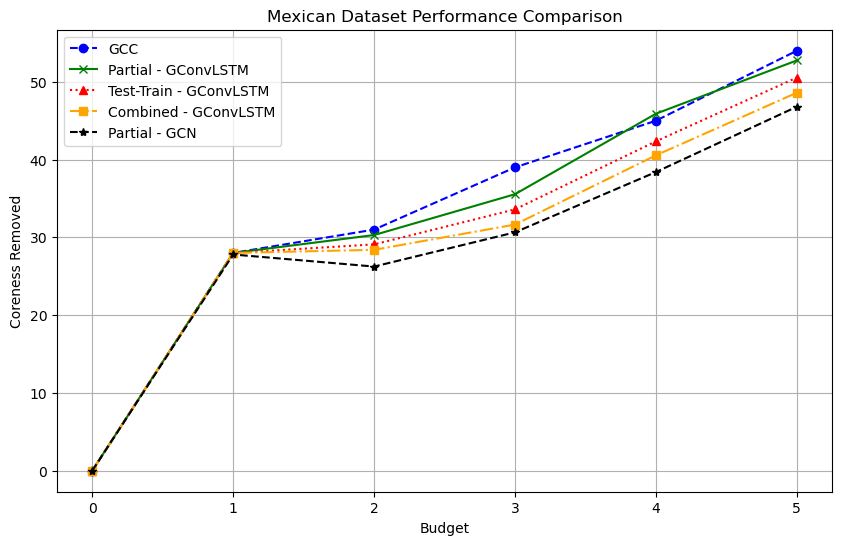

In [ ]:
def compare_without_std(gcc, test_train, sampled, combined, gcn):
    plt.figure(figsize=(10,6))

    plt.plot(range(len(gcc)), gcc, label="GCC", marker="o", linestyle="--", color="blue")

    plt.plot(range(len(sampled)), sampled, label="Partial - GConvLSTM", marker="x", linestyle="-", color="green")
    plt.plot(range(len(test_train)), test_train, label="Test-Train - GConvLSTM", marker="^", linestyle=":", color="red")
    plt.plot(range(len(combined)), combined, label="Combined - GConvLSTM", marker="s", linestyle="-.", color="orange")
    plt.plot(range(len(gcn)), gcn, label="Partial - GCN", marker="*", linestyle="--", color="black")

    plt.xlabel("Budget")
    plt.ylabel("Coreness Removed")
    plt.title(f"Mexican Dataset Performance Comparison")
    plt.legend()
    plt.grid()
    plt.show()

compare_without_std(mexican, lstm_test_train_mean, lstm_sample_mean, lstm_combine_mean, gcn_sample_mean)

In [ ]:
mexican_comparison = {'lstm_sample': [[0, 28, 31, 39, 43, 56],
  [0, 28, 31, 38, 51, 55],
  [0, 28, 31, 39, 43, 56],
  [0, 28, 31, 39, 43, 56],
  [0, 28, 31, 34, 53, 54],
  [0, 28, 31, 34, 53, 55],
  [0, 28, 31, 38, 51, 55],
  [0, 28, 31, 32, 43, 55],
  [0, 28, 30, 40, 52, 54],
  [0, 28, 31, 33, 42, 51],
  [0, 28, 31, 34, 44, 56],
  [0, 28, 23, 26, 30, 32],
  [0, 28, 31, 39, 38, 47],
  [0, 28, 31, 34, 53, 55],
  [0, 28, 31, 34, 53, 55],
  [0, 28, 31, 34, 53, 55],
  [0, 28, 31, 34, 44, 56],
  [0, 28, 31, 39, 43, 56],
  [0, 28, 27, 31, 34, 42],
  [0, 28, 30, 40, 52, 54]],
 'lstm_test_train': [[0, 28, 30, 38, 42, 53],
  [0, 28, 31, 33, 50, 54],
  [0, 28, 29, 32, 40, 45],
  [0, 28, 30, 38, 43, 54],
  [0, 28, 29, 32, 40, 45],
  [0, 28, 28, 31, 37, 50],
  [0, 28, 29, 32, 48, 53],
  [0, 28, 28, 35, 42, 50],
  [0, 28, 29, 32, 48, 48],
  [0, 28, 28, 23, 30, 37],
  [0, 28, 28, 35, 37, 50],
  [0, 28, 28, 31, 37, 50],
  [0, 28, 30, 34, 44, 55],
  [0, 28, 29, 32, 48, 53],
  [0, 28, 30, 38, 44, 53],
  [0, 28, 30, 38, 43, 54],
  [0, 28, 30, 38, 42, 53],
  [0, 28, 28, 31, 37, 50],
  [0, 28, 30, 34, 53, 54],
  [0, 28, 28, 35, 42, 50]],
 'lstm_combine': [[0, 28, 28, 31, 36, 51],
  [0, 28, 30, 33, 40, 50],
  [0, 28, 30, 34, 53, 54],
  [0, 28, 28, 35, 42, 50],
  [0, 28, 29, 32, 43, 53],
  [0, 28, 30, 28, 38, 40],
  [0, 28, 29, 33, 40, 51],
  [0, 28, 30, 28, 30, 49],
  [0, 28, 30, 34, 44, 53],
  [0, 28, 31, 34, 44, 56],
  [0, 28, 28, 33, 42, 46],
  [0, 28, 23, 25, 29, 48],
  [0, 28, 30, 38, 50, 50],
  [0, 28, 30, 34, 53, 55],
  [0, 28, 28, 31, 37, 50],
  [0, 28, 30, 34, 44, 39],
  [0, 28, 23, 26, 26, 37],
  [0, 28, 28, 31, 48, 52],
  [0, 28, 30, 33, 43, 51],
  [0, 28, 23, 26, 29, 37]],
 'gcn': [[0, 28, 30, 38, 44, 51],
  [0, 28, 23, 26, 33, 39],
  [0, 28, 23, 26, 28, 45],
  [0, 28, 23, 25, 33, 38],
  [0, 28, 30, 38, 50, 53],
  [0, 28, 23, 25, 33, 45],
  [0, 28, 29, 31, 38, 50],
  [0, 28, 23, 25, 33, 39],
  [0, 28, 23, 25, 33, 39],
  [0, 28, 30, 38, 50, 54],
  [0, 28, 30, 33, 40, 50],
  [0, 28, 30, 36, 43, 54],
  [0, 28, 23, 25, 33, 45],
  [0, 28, 30, 38, 44, 51],
  [0, 28, 30, 33, 40, 50],
  [0, 28, 30, 38, 44, 56],
  [0, 26, 21, 25, 33, 39],
  [0, 28, 23, 25, 33, 45],
  [0, 26, 21, 25, 33, 39],
  [0, 28, 30, 38, 50, 54]]}

In [ ]:
strike_comparison = {'lstm_sample': [[0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 11, 13]],
 'lstm_test_train': [[0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 10, 9, 11],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 13]],
 'lstm_combine': [[0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 11, 10],
  [0, 4, 7, 10, 12, 11],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 14],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 8, 11, 13],
  [0, 4, 7, 8, 11, 10],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 11, 13],
  [0, 4, 7, 10, 10, 11],
  [0, 4, 7, 10, 12, 12],
  [0, 4, 7, 8, 11, 10],
  [0, 4, 7, 10, 12, 16]],
 'gcn': [[0, 4, 6, 8, 11, 12],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 6, 9, 10, 12],
  [0, 4, 7, 9, 10, 12],
  [0, 4, 7, 8, 7, 7],
  [0, 4, 7, 9, 11, 12],
  [0, 4, 7, 8, 11, 14],
  [0, 4, 7, 8, 10, 12],
  [0, 4, 7, 8, 10, 13],
  [0, 4, 7, 9, 10, 12],
  [0, 4, 2, 5, 8, 10],
  [0, 4, 7, 8, 10, 13],
  [0, 4, 7, 8, 10, 12],
  [0, 4, 2, 5, 8, 9],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 9, 11],
  [0, 4, 7, 10, 12, 13],
  [0, 4, 7, 10, 12, 16],
  [0, 4, 7, 8, 11, 13]]}

In [ ]:
karate_comparison = {'lstm_sample': [[0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50]],
 'lstm_test_train': [[0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 44, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 42, 48],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 44, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 46, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50]],
 'lstm_combine': [[0, 18, 27, 39, 46, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 46, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 44, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 44, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 46, 50],
  [0, 18, 27, 39, 47, 50]],
 'gcn': [[0, 18, 27, 41, 47, 50],
  [0, 18, 27, 40, 46, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 48],
  [0, 18, 27, 41, 44, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 39, 43, 48],
  [0, 18, 23, 39, 47, 50],
  [0, 18, 27, 39, 47, 50],
  [0, 18, 27, 40, 46, 50],
  [0, 18, 27, 41, 47, 50],
  [0, 18, 27, 41, 47, 50]]}

In [ ]:
football_comparison = {'lstm_sample': [[0, 6, 6, 18, 22, 30, 56, 81, 92, 102, 111],
  [0, 6, 18, 26, 43, 71, 85, 99, 108, 114, 123],
  [0, 6, -2, 11, 14, 22, 38, 56, 71, 82, 95],
  [0, 6, 9, 21, 21, 46, 82, 93, 106, 114, 123],
  [0, 6, 7, 45, 71, 73, 85, 97, 106, 114, 119],
  [0, 6, 24, 44, 71, 74, 84, 96, 105, 113, 119],
  [0, 6, 6, 18, 43, 43, 80, 85, 101, 112, 120],
  [0, 6, 17, 25, 42, 69, 83, 94, 102, 111, 117],
  [0, 6, 17, 25, 43, 69, 79, 90, 101, 110, 119],
  [0, 6, 17, 17, 28, 36, 65, 89, 101, 110, 118],
  [0, 6, 13, 24, 43, 54, 72, 81, 92, 100, 111],
  [0, 6, 14, 44, 70, 80, 91, 102, 112, 121, 130],
  [0, 6, 18, 27, 35, 53, 79, 89, 100, 109, 117],
  [0, 6, 6, 17, 44, 44, 80, 97, 111, 122, 136],
  [0, 6, 6, 27, 48, 65, 83, 95, 106, 115, 123],
  [0, 6, 13, 24, 43, 54, 69, 80, 94, 102, 119],
  [0, 6, 6, 18, 47, 73, 83, 95, 104, 112, 115],
  [0, 6, 14, 44, 70, 80, 91, 100, 108, 111, 118],
  [0, 6, 6, 44, 70, 68, 80, 91, 102, 111, 117],
  [0, 6, 24, 45, 72, 82, 96, 105, 112, 120, 130]],
  'lstm_test_train': [[0, 6, 6, 21, 45, 47, 74, 73, 106, 107, 125],
  [0, 6, 19, 22, 30, 29, 47, 72, 99, 98, 109],
  [0, 6, 6, 25, 25, 54, 63, 78, 98, 96, 107],
  [0, 6, 7, 25, 25, 83, 82, 103, 109, 120, 129],
  [0, 6, 19, 23, 31, 38, 55, 91, 105, 104, 114],
  [0, 6, 7, 26, 26, 84, 83, 103, 104, 115, 130],
  [0, 6, 6, 27, 26, 46, 63, 68, 86, 111, 109],
  [0, 6, 6, 17, 22, 31, 36, 62, 74, 104, 112],
  [0, 6, 12, 23, 24, 53, 52, 70, 80, 90, 112],
  [0, 6, 6, 27, 26, 52, 62, 80, 79, 91, 100],
  [0, 6, 7, 18, 43, 42, 69, 68, 88, 89, 118],
  [0, 6, 7, 24, 23, 52, 73, 89, 93, 119, 129],
  [0, 6, 7, 25, 25, 54, 71, 81, 89, 98, 108],
  [0, 6, 6, 27, 26, 52, 62, 80, 79, 88, 87],
  [0, 6, 6, 19, 29, 38, 37, 63, 76, 102, 119],
  [0, 6, 7, 24, 24, 53, 73, 78, 94, 105, 116],
  [0, 6, 7, 45, 44, 70, 69, 88, 90, 113, 124],
  [0, 6, 6, 24, 24, 52, 62, 83, 82, 91, 98],
  [0, 6, 7, 43, 44, 70, 69, 88, 86, 109, 120],
  [0, 6, 6, 19, 22, 27, 36, 45, 64, 81, 85]],
  'lstm_combine': [[0, 6, 13, 12, 24, 26, 47, 57, 72, 96, 107],
  [0, 6, 7, 9, 44, 61, 72, 80, 99, 101, 111],
  [0, 6, 13, 24, 23, 49, 49, 74, 110, 117, 128],
  [0, 6, 7, 14, 45, 44, 70, 70, 90, 102, 115],
  [0, 6, 6, 17, 16, 24, 45, 56, 73, 89, 97],
  [0, 6, 6, 6, 11, 21, 41, 51, 54, 80, 79],
  [0, 6, 19, 19, 27, 31, 57, 56, 82, 99, 113],
  [0, 6, 7, 7, 45, 44, 44, 92, 91, 101, 118],
  [0, 6, 7, 19, 45, 44, 70, 71, 102, 100, 112],
  [0, 6, 7, 21, 46, 46, 72, 72, 103, 102, 113],
  [0, 6, 19, 23, 31, 42, 42, 59, 68, 67, 85],
  [0, 6, 7, 8, 44, 44, 69, 61, 72, 91, 89],
  [0, 6, 7, 14, 45, 49, 75, 74, 88, 97, 107],
  [0, 6, 13, 25, 24, 44, 62, 60, 59, 85, 84],
  [0, 6, 18, 23, 31, 30, 46, 63, 62, 72, 87],
  [0, 6, 7, 45, 44, 70, 71, 90, 89, 100, 113],
  [0, 6, 19, 27, 27, 45, 82, 81, 90, 103, 102],
  [0, 6, 7, 7, 44, 44, 70, 62, 80, 78, 89],
  [0, 6, 18, 18, 26, 42, 41, 58, 66, 76, 87],
  [0, 6, 7, 19, 43, 44, 70, 70, 101, 99, 109]],
  'gcn': [[0, 6, 6, 6, 8, 22, 31, 76, 75, 85, 97],
 [0, 6, 7, 18, 18, 18, 41, 41, 71, 70, 80],
 [0, 6, 14, 13, 35, 52, 52, 77, 88, 96, 105],
 [0, 6, 6, 6, 11, 11, 29, 29, 29, 95, 95],
 [0, 6, 14, 14, 43, 69, 68, 79, 88, 96, 106],
 [0, 6, 6, 6, 10, 16, 16, 19, 28, 42, 44],
 [0, 6, -2, 11, 13, 17, 16, 16, 41, 41, 40],
 [0, 6, 6, 6, 6, 42, 41, 53, 64, 64, 74],
 [0, 5, -3, 16, 20, 20, 38, 47, 76, 84, 92],
 [0, 6, -2, 11, 13, 12, 12, 11, 19, 24, 44],
 [0, 6, 7, 21, 26, 18, 36, 36, 38, 64, 95],
 [0, 6, 7, 20, 20, 24, 48, 50, 63, 89, 102],
 [0, 6, -2, -2, -1, -2, -3, 3, 3, 14, 14],
 [0, 6, -2, 17, 16, 35, 55, 81, 80, 86, 84],
 [0, 6, 6, 7, 9, 8, 8, 9, 71, 70, 81],
 [0, 6, 6, 6, 6, 29, 41, 41, 75, 74, 66],
 [0, 6, 6, 6, 6, 6, 16, 49, 60, 75, 74],
 [0, 6, 14, 14, 14, 17, 22, 71, 71, 88, 98],
 [0, 6, 18, 17, 19, 17, 17, 20, 25, 29, 49],
 [0, 6, 7, 21, 21, 44, 47, 73, 73, 72, 72]]}